In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import numba
import anndata
from scipy import sparse
import os,time,datetime,sys,pickle
from sklearn.model_selection import train_test_split

In [ ]:
import umap
from sklearn.manifold import TSNE

from scipy import stats as st
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sknetwork.clustering import Louvain

from scipy.io import mmread
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

import tarfile as tar
import csv
import gzip
import os
import scipy.io

# This notebook is kindoff like our draft notebook # 

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.14.0.dev794+g5b586d714 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [4]:
os.getcwd()

'/Users/dsoler/Desktop/Stat ML for Genomics'

# 01. Read Singlecell files #

In [5]:
path1= '/Users/dsoler/Desktop/Stat ML for Genomics/TBI Project/bTBI 2'
path2= '/Users/dsoler/Desktop/Stat ML for Genomics/TBI Project/Sham 2'

bTBI = sc.read_10x_mtx(path1, cache=True)
sham = sc.read_10x_mtx(path2, cache=True)

... reading from cache file cache/Users-dsoler-Desktop-Stat ML for Genomics-TBI Project-bTBI 2-matrix.h5ad
... reading from cache file cache/Users-dsoler-Desktop-Stat ML for Genomics-TBI Project-Sham 2-matrix.h5ad


In [6]:
bTBI.obs['bTBI']=True
sham.obs['bTBI']=False
bTBI.obs['condition'] = 'bTBI'
sham.obs['condition'] = 'sham'

# 02. Concatenate adata #

In [7]:
adata = bTBI.concatenate(sham)

/Applications/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


normalizing counts per cell
    finished (0:00:00)


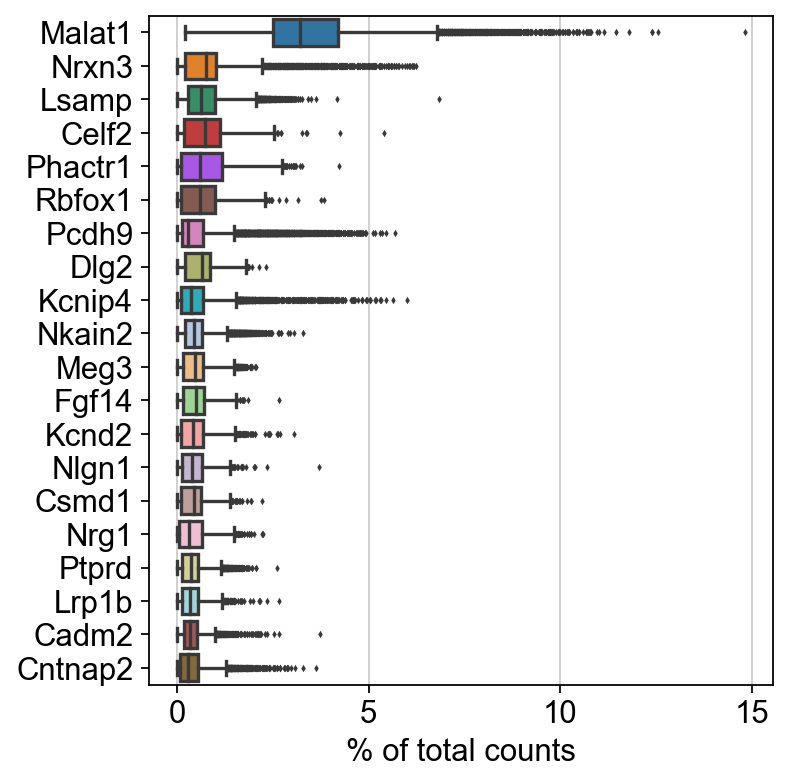

In [8]:
sc.pl.highest_expr_genes(adata, n_top = 20)

# 03. Preprocessing. Filter cells (min genes=200) and genes (min cells = 3). Normalization by median library size #

In [9]:
QC_metrics = sc.pp.calculate_qc_metrics(adata)

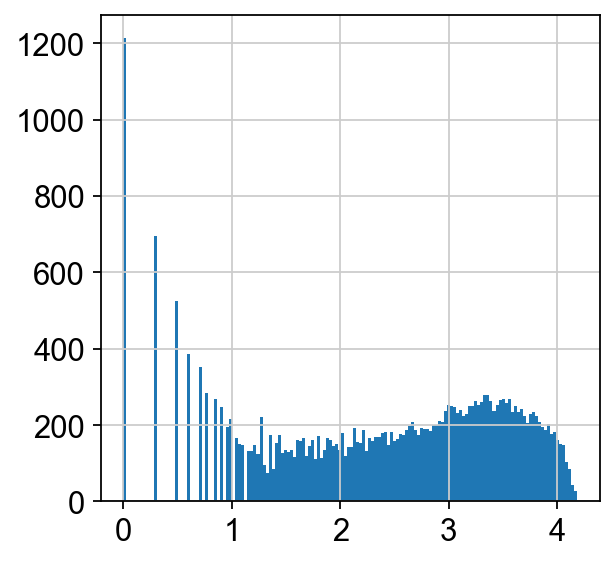

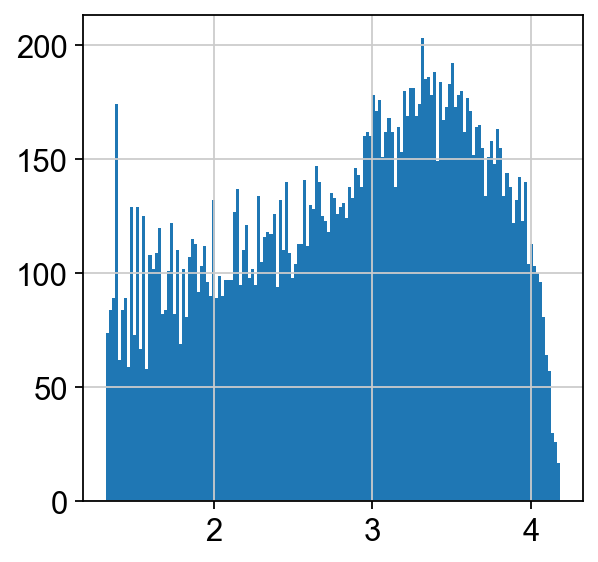

In [10]:
cells_per_gene = QC_metrics[1]['n_cells_by_counts']
cells_per_gene = cells_per_gene[cells_per_gene > 0]
filtered_cells_per_gene = cells_per_gene[cells_per_gene > 20]
plt.figure(1)
histogram = plt.hist(np.log10(cells_per_gene), 150)
plt.figure(2)
histogram = plt.hist(np.log10(filtered_cells_per_gene), 150)

In [11]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.filter_cells(adata, min_genes=200)

filtered out 11860 genes that are detected in less than 20 cells


In [12]:
median_lib_size = np.median(QC_metrics[0]['total_counts'])
sc.pp.normalize_total(adata, target_sum=median_lib_size)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


# 04. Find Highly Variable Genes #

In [13]:

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [30]:
#genies = list(adata.var_names)

In [31]:
#file = open('genies.pkl', 'wb')
#pickle.dump(genies, file)
#file.close()

# 04. PCA and UMAP #

In [15]:
sc.pp.neighbors(adata, knn=True) #run twice for some reason and the next blocks to get the right graph
sc.pp.pca(adata, n_comps = 10, use_highly_variable=True, svd_solver='arpack')

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)


In [16]:
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.louvain(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)


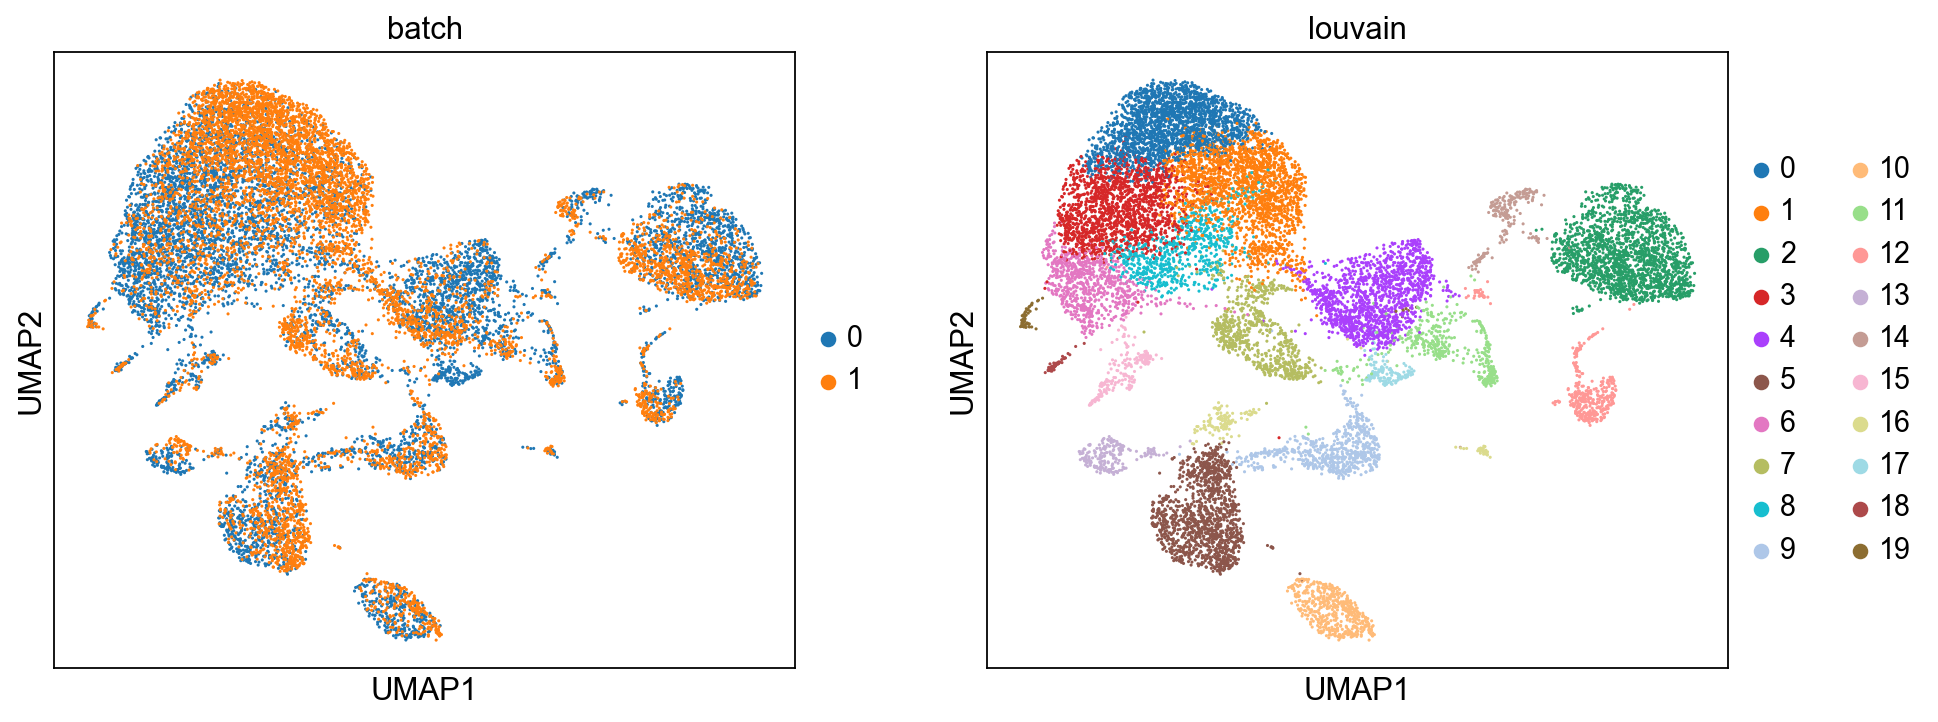

In [17]:
sc.settings.set_figure_params(figsize=(6,5))
sc.pl.umap(adata, color = ['batch','louvain'])

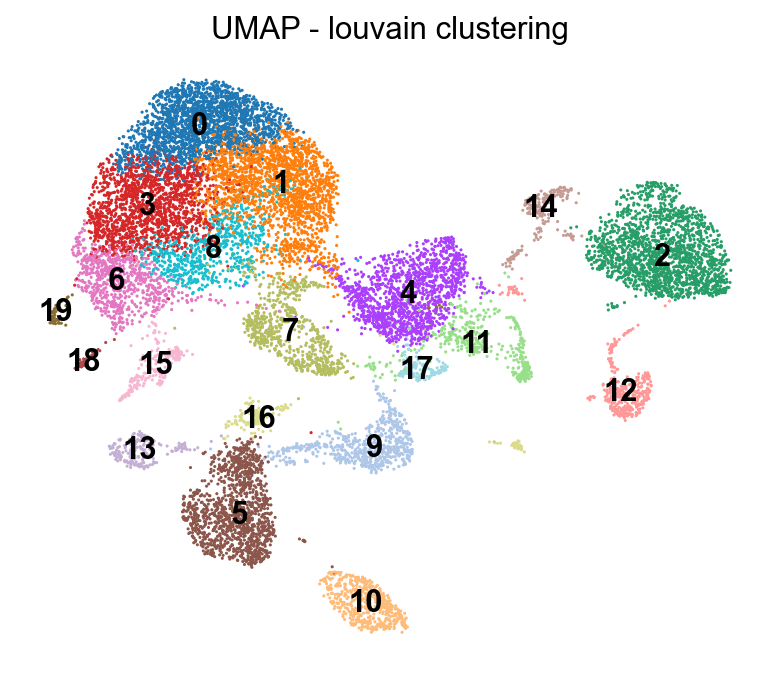

In [19]:
sc.settings.set_figure_params(figsize=(6,5))
sc.pl.umap(adata, color = ['louvain'], legend_loc='on data', frameon = False, title = "UMAP - louvain clustering")

These cells are found in the SVZ, therefore some cell types that we expect to have include Ependymal, Astrocyte-NSC, Microglia, Endothelial&Mural, Neuron, Oligodendrocyte, OPC. 



# 05. Finding Top Genes #

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


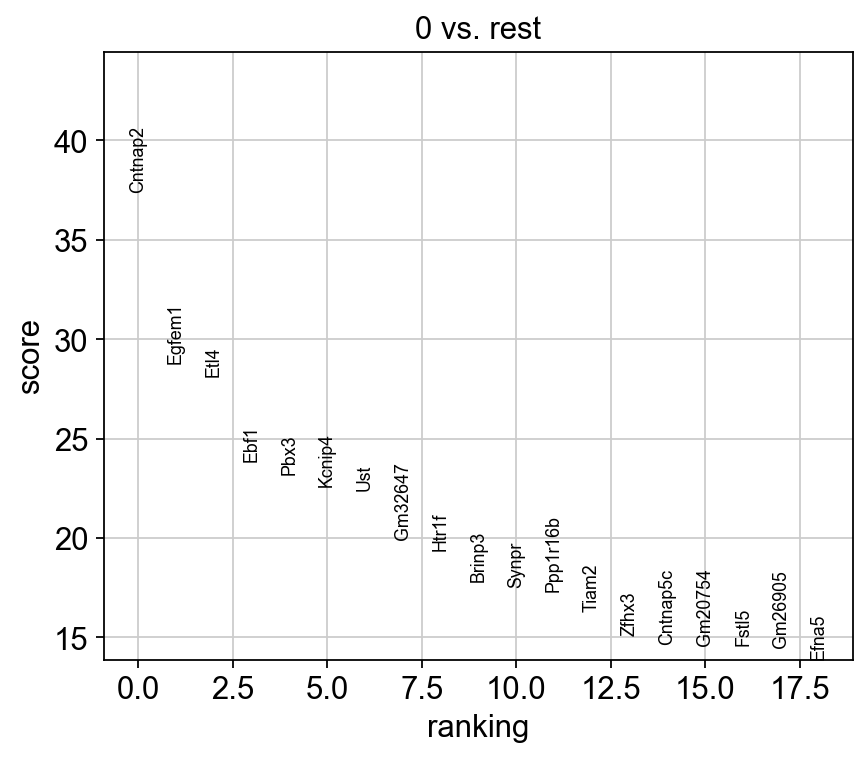

In [20]:
sc.tl.rank_genes_groups(adata, groupby='louvain', groups=['0'], method='wilcoxon') #paper uses this test
sc.pl.rank_genes_groups(adata, n_genes=19, sharey=False)
result = adata.uns['rank_genes_groups']
DEGs = result['names'].dtype.names
DEGs = result['names']

In [21]:
print(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(19))


           0
0    Cntnap2
1     Egfem1
2       Etl4
3       Ebf1
4       Pbx3
5     Kcnip4
6        Ust
7    Gm32647
8      Htr1f
9     Brinp3
10     Synpr
11  Ppp1r16b
12     Tiam2
13     Zfhx3
14  Cntnap5c
15   Gm20754
16     Fstl5
17   Gm26905
18     Efna5


In [31]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

df

0_n            0_p
0     Cntnap2  2.576977e-306
1      Egfem1  4.861021e-182
2        Etl4  2.990152e-174
3        Ebf1  1.115166e-125
4        Pbx3  4.095517e-119
...       ...            ...
1995   mt-Co2  1.819808e-252
1996   Slc8a1  7.039890e-299
1997   mt-Co1  1.198057e-304
1998  mt-Atp6   0.000000e+00
1999   mt-Co3   0.000000e+00

[2000 rows x 2 columns]

In [54]:
df[df['0_n'] == 'Gfap']

0_n       0_p
527  Gfap  0.799844

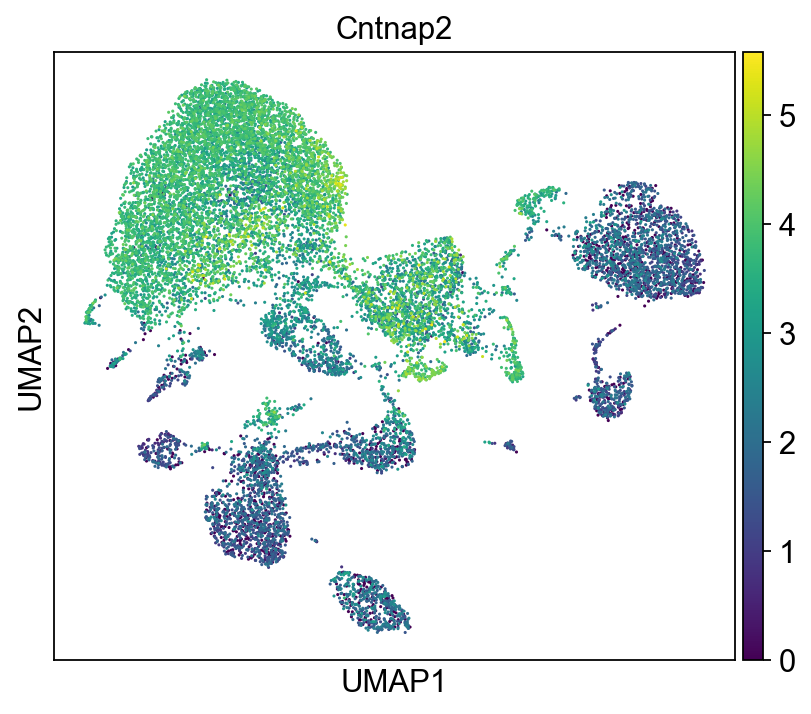

In [57]:
sc.pl.umap(adata, color=['Cntnap2']) #'Abcg2', 'Vim', 'Dcx',

# 06. Finding Marker genes. Plot dotplots and get dataframe #

    using 'X_pca' with n_pcs = 10
Storing dendrogram info using `.uns['dendrogram_louvain']`
categories: 0, 1, 2, etc.
var_group_labels: 0


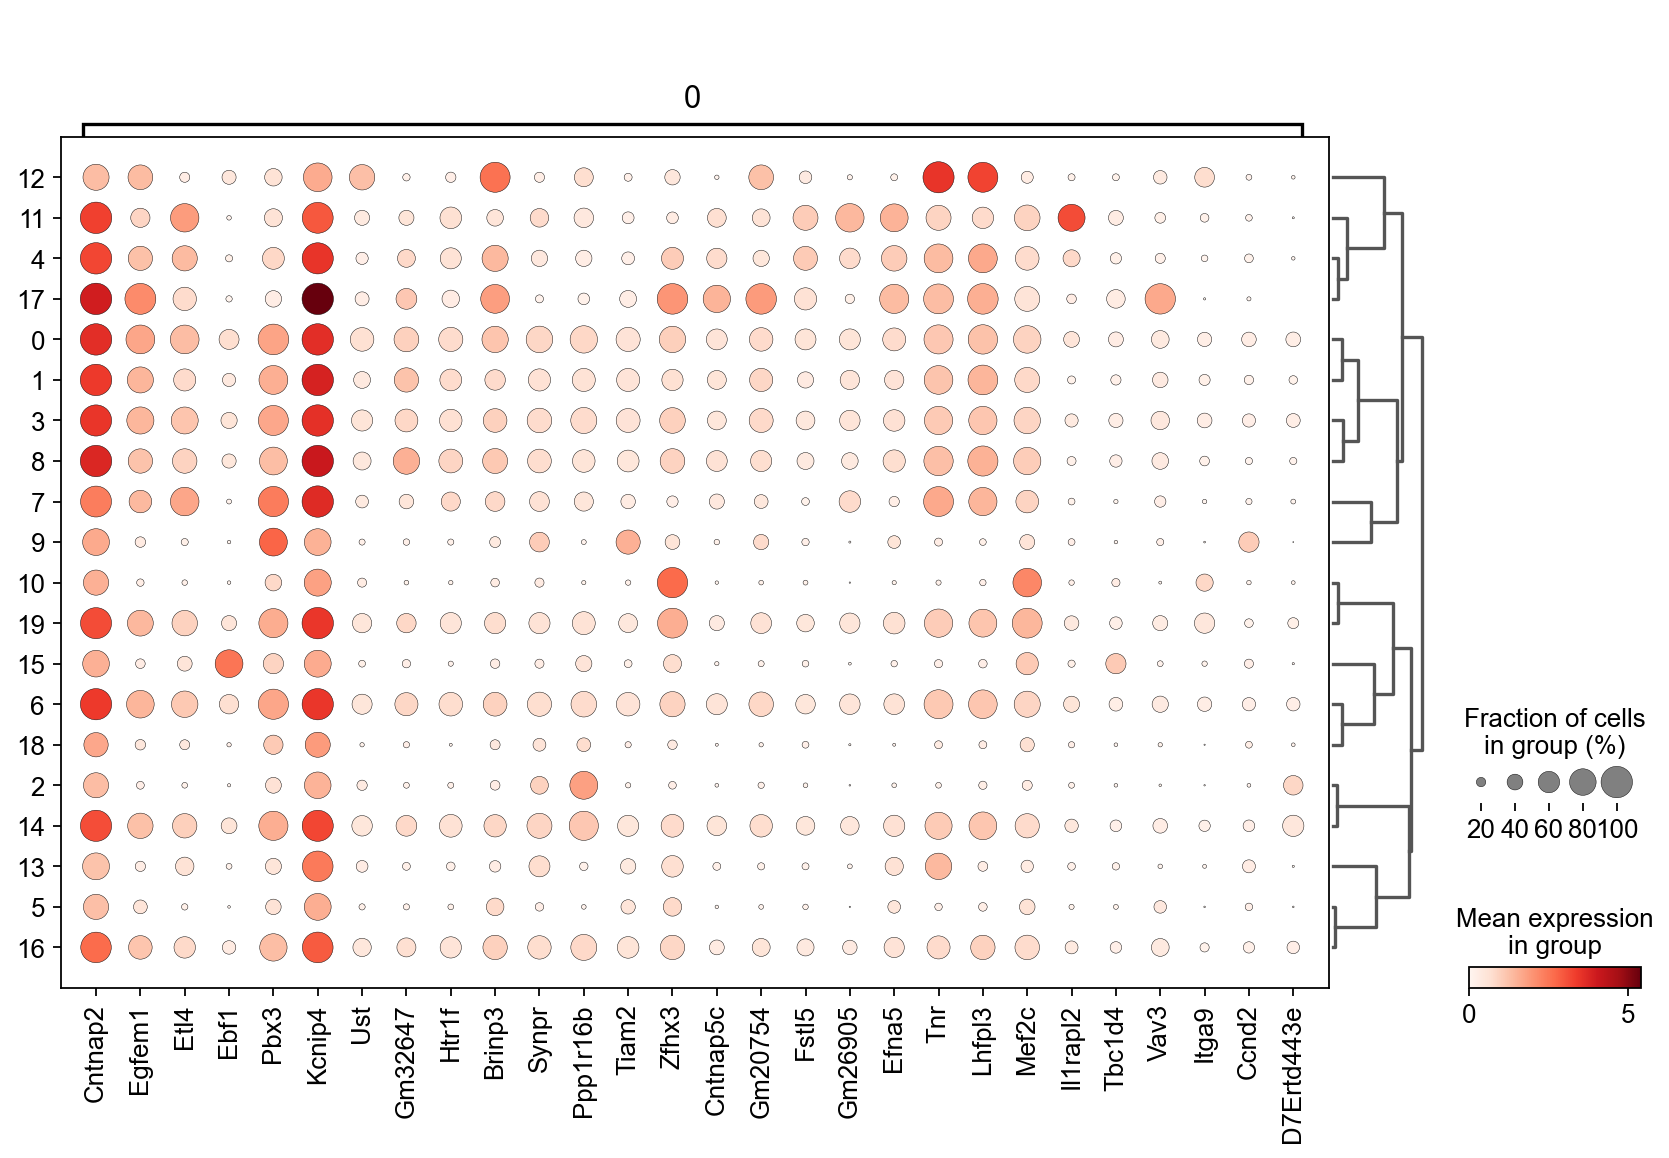

In [42]:
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups', n_genes=28)

In [43]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.25, max_out_group_fraction: 0.5


In [44]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:]: result[key][group]
                for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
df_level1 = df

In [99]:
df

0_names    0_pvals_adj  0_logfoldchanges        1_names    1_pvals_adj  \
0     Cntnap2  1.717985e-303          1.590263         Kcnip4  1.420377e-262   
1      Egfem1  8.101702e-180          1.391875  C130073E24Rik  2.384528e-200   
2        Etl4  4.271646e-172          1.222683        Arhgap6  1.868915e-193   
3        Ebf1  8.578201e-124          1.557234        Fam19a2  2.686114e-155   
4        Pbx3  2.925369e-117          0.943800        Col25a1  1.734017e-149   
...       ...            ...               ...            ...            ...   
1995   mt-Co2  6.066027e-250         -1.867105        mt-Cytb  5.745645e-210   
1996   Slc8a1  2.815956e-296         -3.442320         mt-Co2  2.285803e-248   
1997   mt-Co1  5.990285e-302         -1.884533         mt-Co1  1.730487e-251   
1998  mt-Atp6   0.000000e+00         -1.740850        mt-Atp6  9.113105e-291   
1999   mt-Co3   0.000000e+00         -1.903729         mt-Co3   0.000000e+00   

      1_logfoldchanges  2_names  2_pvals_adj  2_logfoldchanges  3_names  ...  \
0             1.522531     Plp1          0.0          4.190149  Cntnap2  ...   
1             1.677828    Pde4b          0.0          3.809922   Kcnip4  ...   
2             1.454526      Mbp          0.0          5.491205     Etl4  ...   
3             1.310308     St18          0.0          7.173266  mt-Atp6  ...   
4             1.262728    Edil3          0.0          4.819975  mt-Cytb  ...   
...                ...      ...          ...               ...      ...  ...   
1995         -1.871386    Grip1          0.0         -3.591597    Erbb4  ...   
1996         -1.887729  Cntnap2          0.0         -2.650536    Fmnl2  ...   
1997         -1.712105   Kcnip4          0.0         -2.709547     Zeb2  ...   
1998         -1.704200   Frmd4a          0.0         -3.273479    Mast4  ...   
1999         -1.821277    Nrxn1          0.0         -2.794857   Slc8a1  ...   

      16_logfoldchanges  17_names  17_pvals_adj  17_logfoldchanges  18_names  \
0              3.654519     Kcnc2  1.570304e-79           5.653388    mt-Nd1   
1              3.016934     Ntng1  5.177948e-78           5.611045    mt-Co3   
2              3.175528    Kcnip4  5.177948e-78           3.610673    mt-Nd4   
3              2.982362     Hdac9  5.177948e-78           3.737764    mt-Co2   
4              4.028314     Zmat4  1.039876e-75           4.206563   mt-Cytb   
...                 ...       ...           ...                ...       ...   
1995          -0.527582     Synpr  2.510321e-18          -3.301221    Srgap2   
1996          -0.468494      Sgcd  1.366400e-18          -2.493458     Grip1   
1997          -0.868502     Erbb4  9.653118e-20          -2.965524     Pde4b   
1998          -0.728053     Ptprt  4.153850e-22          -2.863189     Frmd5   
1999          -1.084240      Pbx3  5.828153e-29          -3.133879    Frmd4a   

      18_pvals_adj  18_logfoldchanges  19_names  19_pvals_adj  \
0     3.025485e-44           6.690929    Inpp5d  2.385496e-26   
1     3.025485e-44           6.606745      Hexb  1.787762e-20   
2     3.025485e-44           6.514613      Fli1  1.072983e-19   
3     3.025485e-44           6.732162   Apbb1ip  2.291355e-19   
4     3.025485e-44           6.598129     Pde3b  4.352473e-19   
...            ...                ...       ...           ...   
1995  9.559492e-14          -2.767039     Pacrg  3.473816e-03   
1996  5.521202e-14          -2.906829      Nfib  2.767538e-03   
1997  1.728487e-14          -2.815821     Edil3  2.064143e-03   
1998  6.857688e-15          -2.938287     Frmd5  1.647738e-03   
1999  5.100926e-20          -3.396937     Npas3  2.699085e-04   

      19_logfoldchanges  
0              4.350577  
1              3.461877  
2              3.877147  
3              3.825616  
4              2.609057  
...                 ...  
1995          -2.126609  
1996          -3.254476  
1997          -2.080975  
1998          -1.005662  
1999          -3.170856  

[2000 rows x 60 columns]

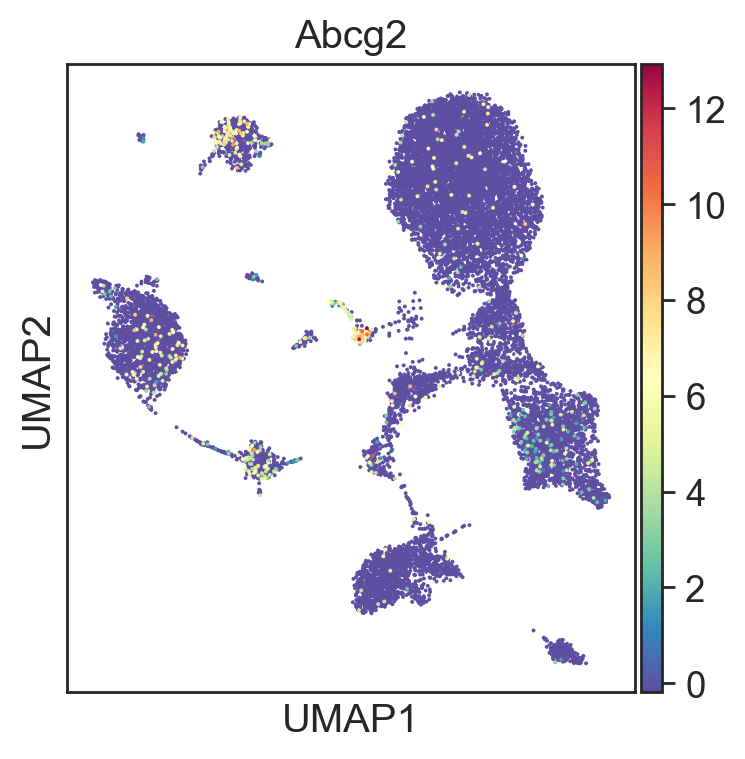

In [120]:
sc.pl.umap(adata, color=['Abcg2'])

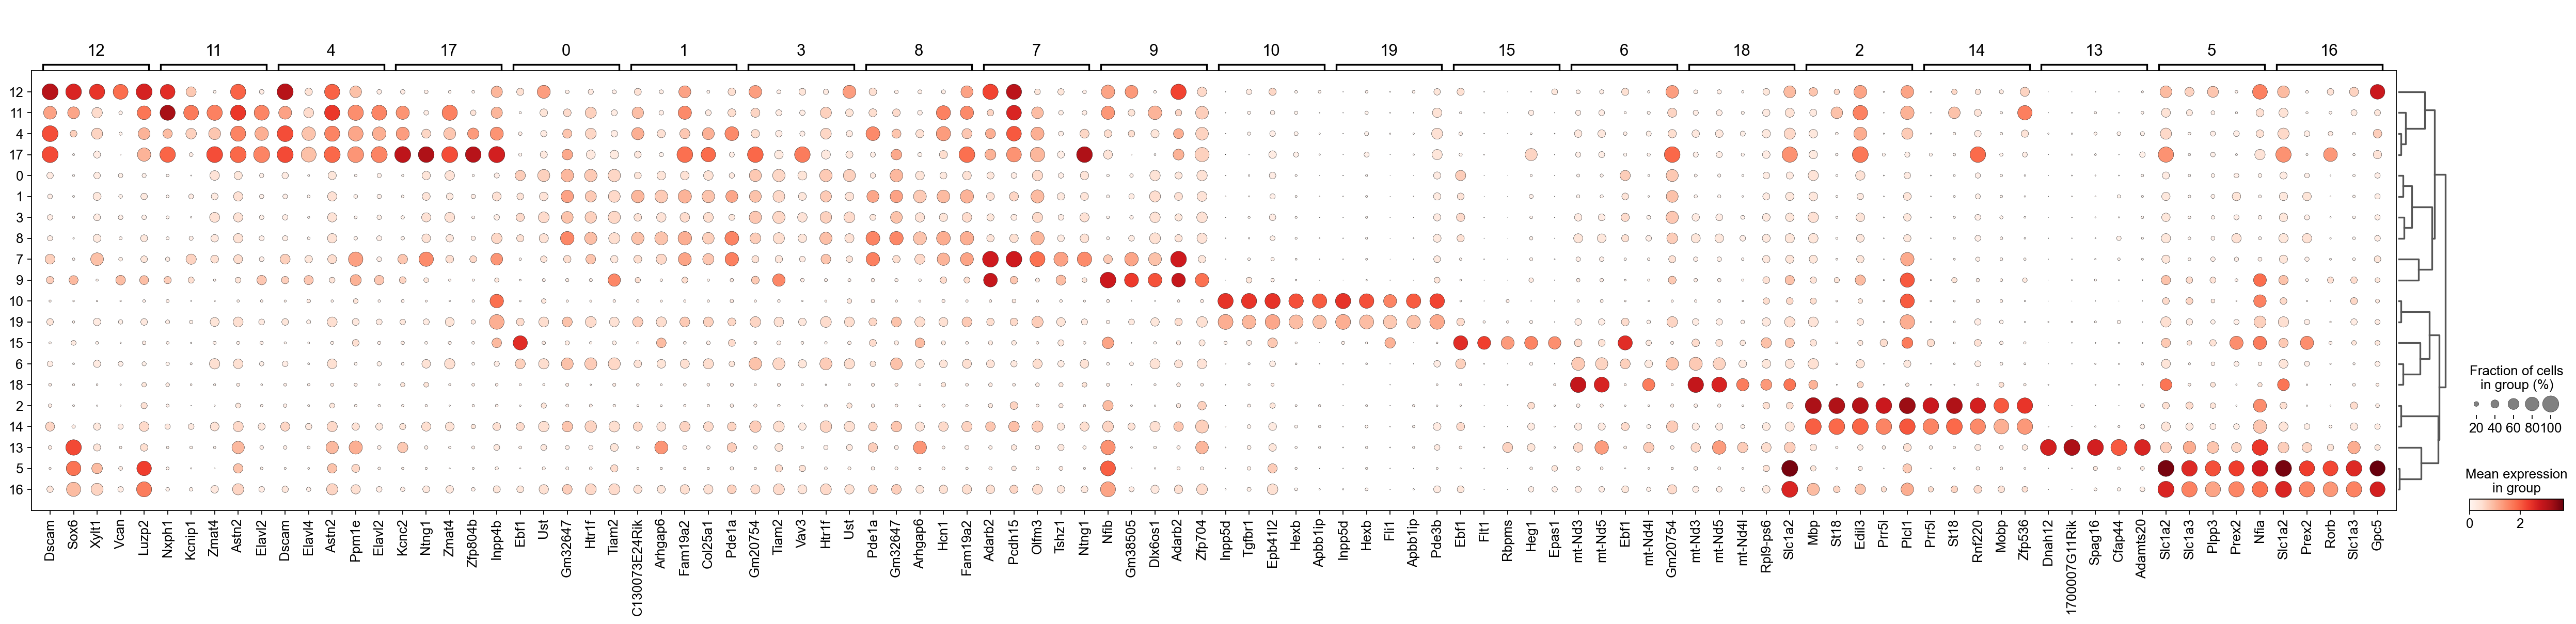

In [45]:

sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups_filtered',  n_genes=5)

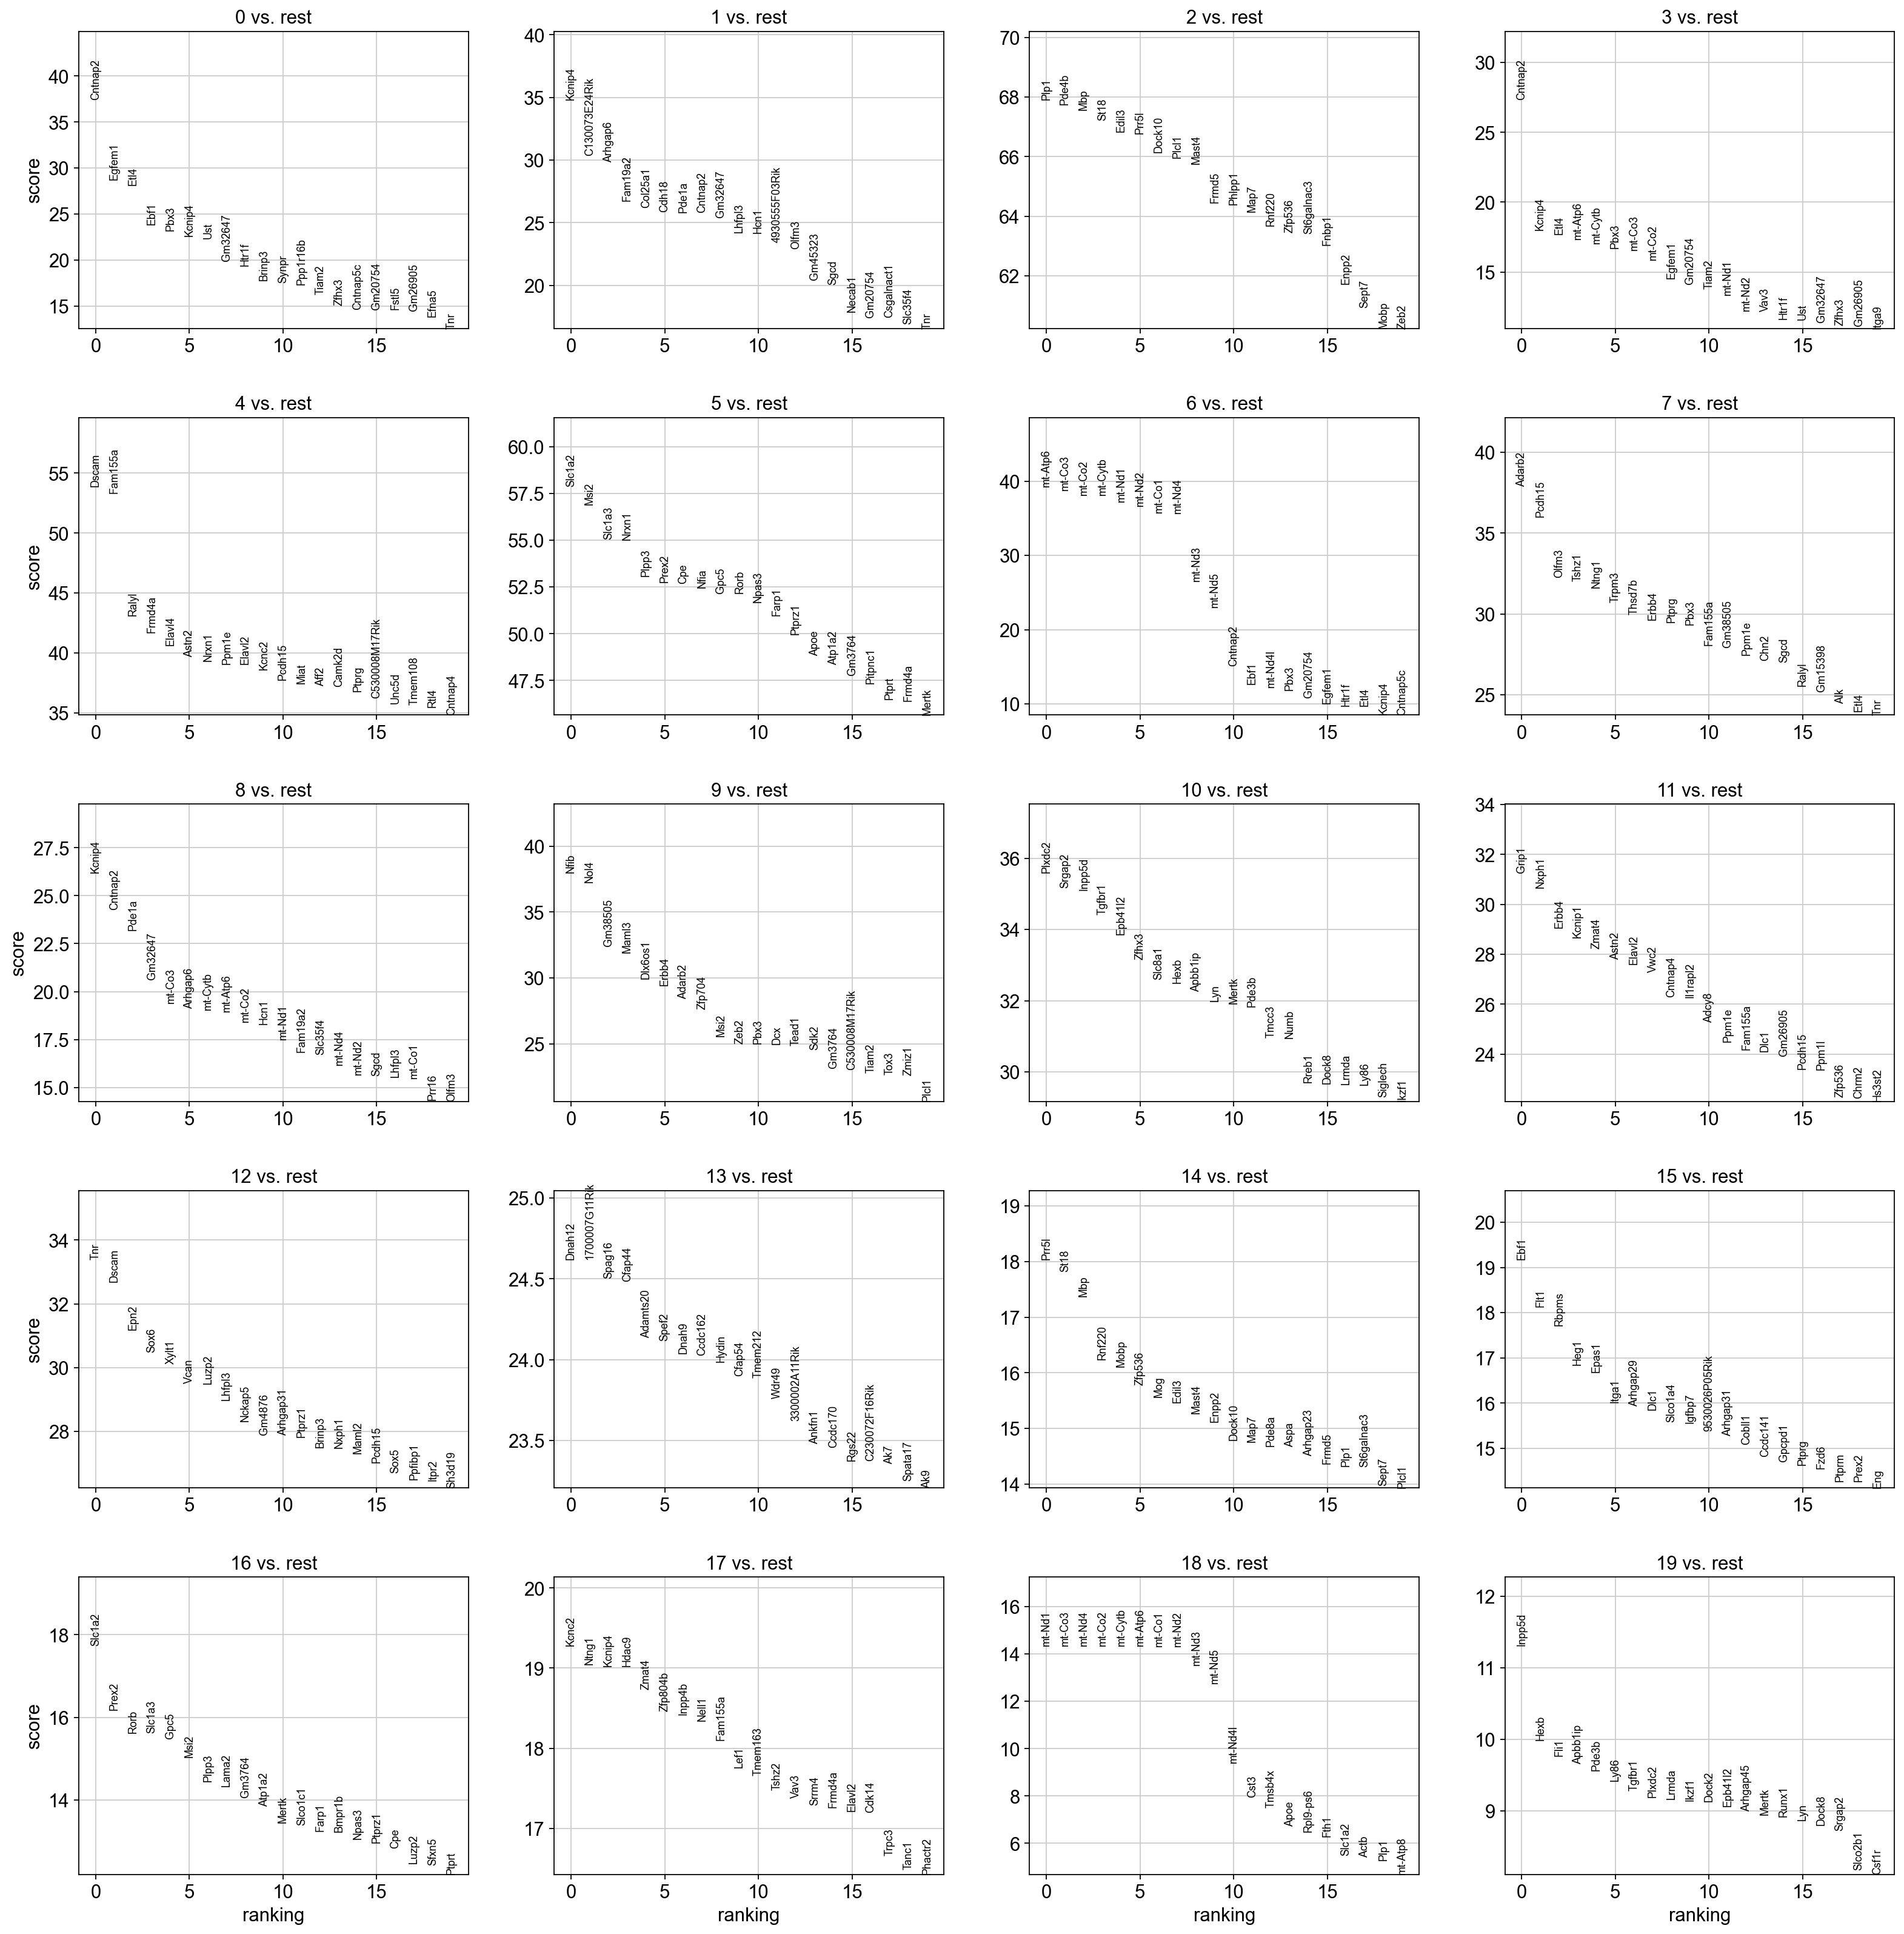

In [46]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [48]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 0.25, max_out_group_fraction: 0.5


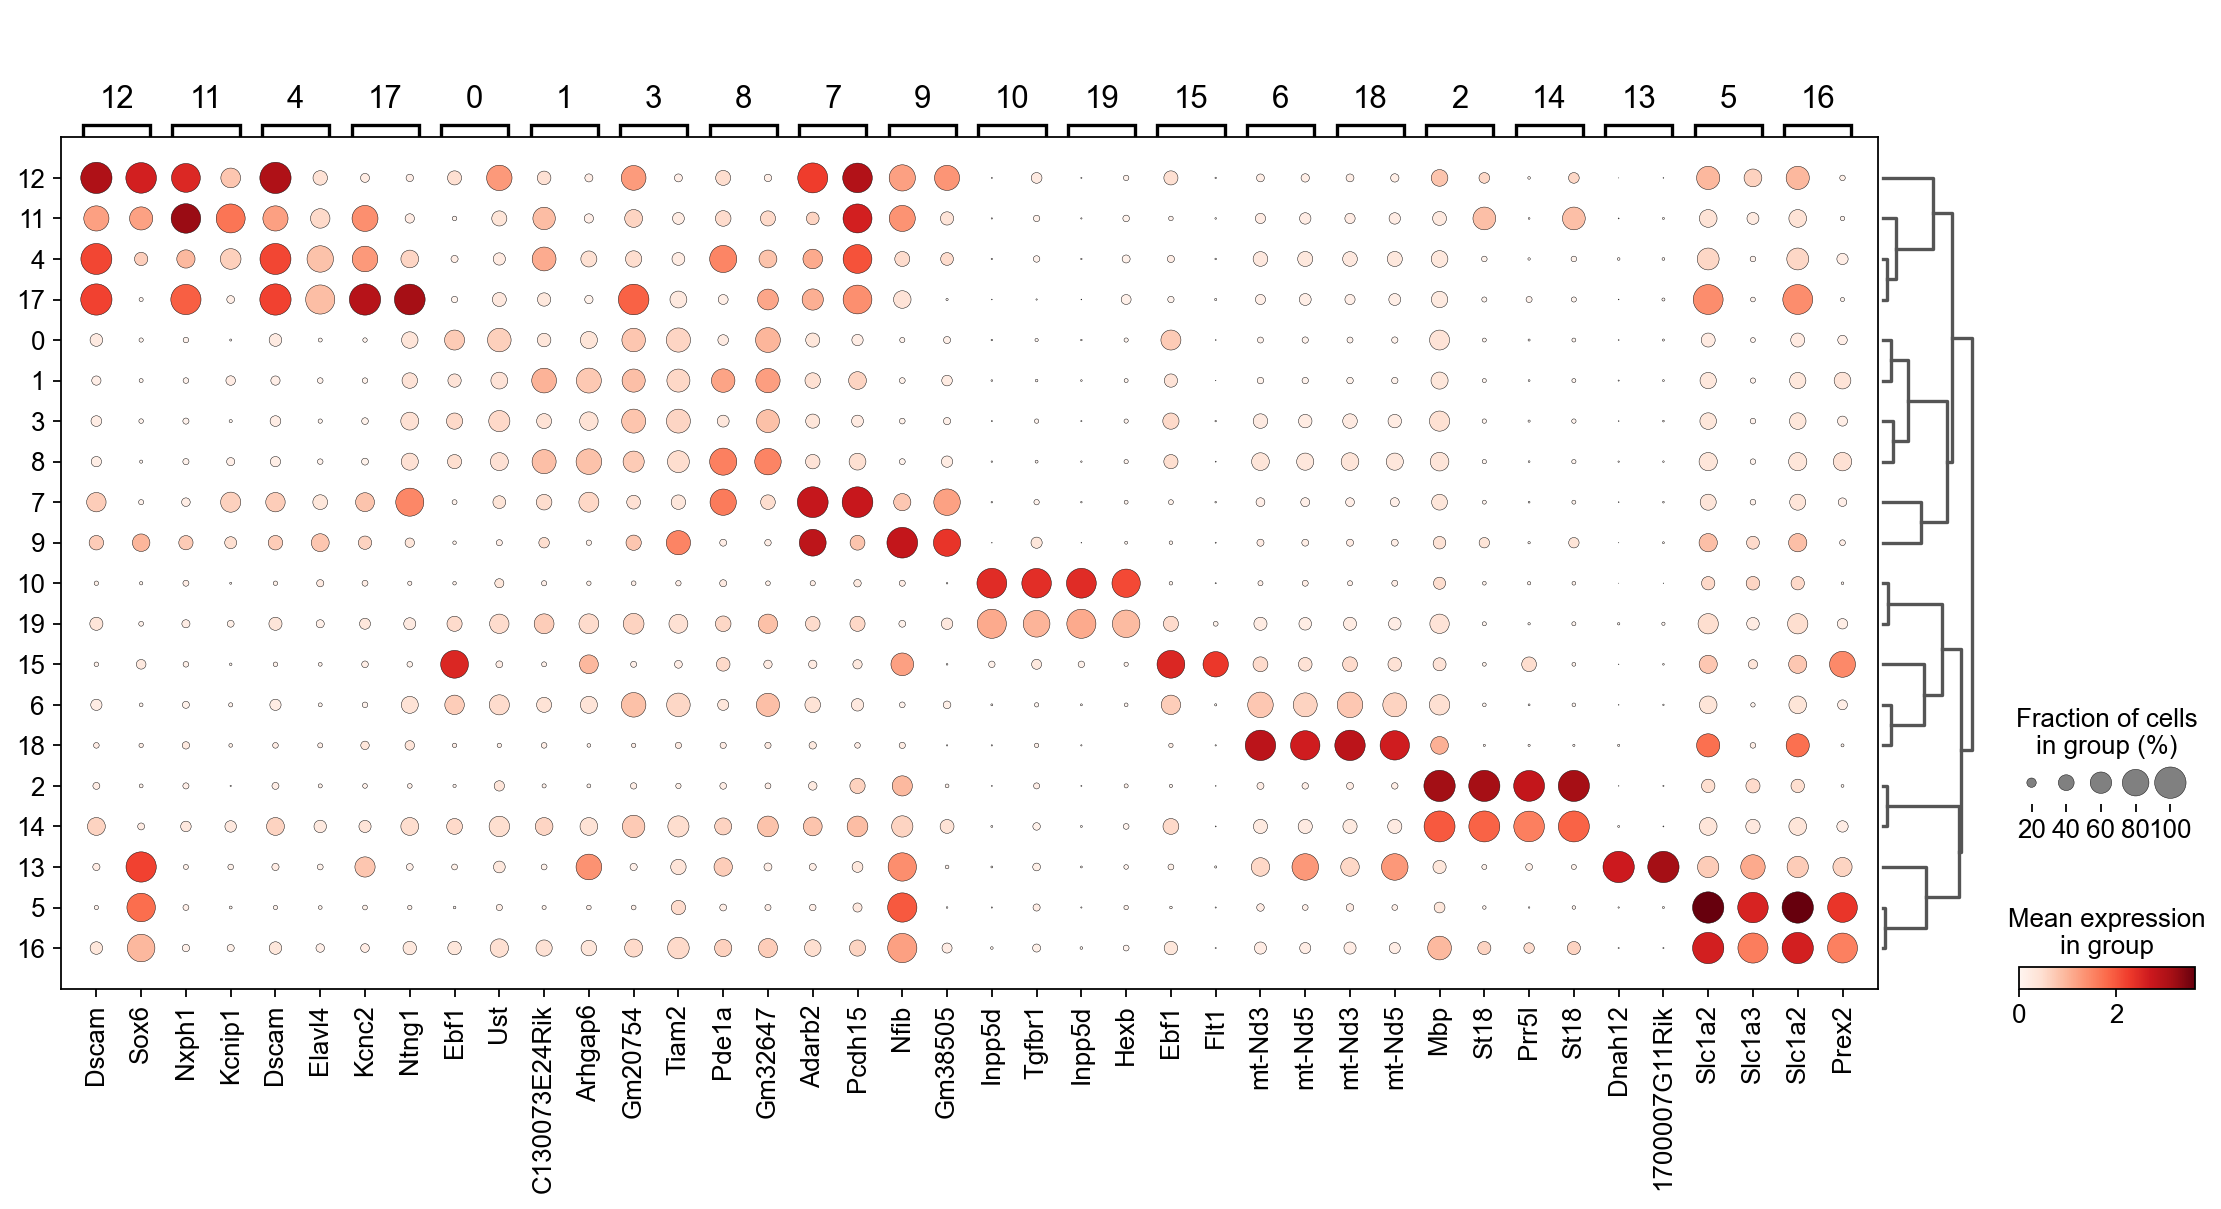

In [49]:
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups_filtered', n_genes=2)

In [110]:
pd.DataFrame(adata.uns['rank_genes_groups']['names'])

0              1        2        3         4           5        6  \
0     Cntnap2         Kcnip4     Plp1  Cntnap2     Dscam      Slc1a2  mt-Atp6   
1      Egfem1  C130073E24Rik    Pde4b   Kcnip4   Fam155a        Msi2   mt-Co3   
2        Etl4        Arhgap6      Mbp     Etl4     Ralyl      Slc1a3   mt-Co2   
3        Ebf1        Fam19a2     St18  mt-Atp6    Frmd4a       Nrxn1  mt-Cytb   
4        Pbx3        Col25a1    Edil3  mt-Cytb    Elavl4       Plpp3   mt-Nd1   
...       ...            ...      ...      ...       ...         ...      ...   
1995   mt-Co2        mt-Cytb    Grip1    Erbb4     Tiam2  St6galnac3    Plcl1   
1996   Slc8a1         mt-Co2  Cntnap2    Fmnl2      Plp1      Dock10     Zeb2   
1997   mt-Co1         mt-Co1   Kcnip4     Zeb2      Pbx3      Kcnip4    Fmnl2   
1998  mt-Atp6        mt-Atp6   Frmd4a    Mast4  Ppp1r16b     Cntnap2    Mast4   
1999   mt-Co3         mt-Co3    Nrxn1   Slc8a1     Cdk19       Frmd5   Slc8a1   

           7        8        9       10      11       12             13  \
0     Adarb2   Kcnip4     Nfib   Plxdc2   Grip1      Tnr         Dnah12   
1     Pcdh15  Cntnap2     Nol4   Srgap2   Nxph1    Dscam  1700007G11Rik   
2      Olfm3    Pde1a  Gm38505   Inpp5d   Erbb4     Epn2         Spag16   
3      Tshz1  Gm32647    Maml3   Tgfbr1  Kcnip1     Sox6         Cfap44   
4      Ntng1   mt-Co3  Dlx6os1  Epb41l2   Zmat4    Xylt1       Adamts20   
...      ...      ...      ...      ...     ...      ...            ...   
1995  Slc9a9    Hipk2     Map7      Tnr    Sgcd    Mef2c         Frmd4a   
1996    Nfia     Nfib    Pde4b    Grip1   Zfhx3   Frmd4a         Dock10   
1997    Zeb2    Plcl1   Lhfpl3    Pde4b   Cdk19     Pbx3          Nrxn1   
1998   Frmd5     Zeb2   Dock10    Frmd5    Pbx3   Kcnip4        Cntnap2   
1999   Zfhx3     Nfia   Kcnip4    Nrxn1   Pde4b  Cntnap2          Pde4b   

          14       15       16      17       18       19  
0      Prr5l     Ebf1   Slc1a2   Kcnc2   mt-Nd1   Inpp5d  
1       St18     Flt1    Prex2   Ntng1   mt-Co3     Hexb  
2        Mbp    Rbpms     Rorb  Kcnip4   mt-Nd4     Fli1  
3     Rnf220     Heg1   Slc1a3   Hdac9   mt-Co2  Apbb1ip  
4       Mobp    Epas1     Gpc5   Zmat4  mt-Cytb    Pde3b  
...      ...      ...      ...     ...      ...      ...  
1995   Mertk  Cntnap2   Plxna4   Synpr   Srgap2    Pacrg  
1996    Sox6    Pde4b      Tnr    Sgcd    Grip1     Nfib  
1997    Gpc5   Frmd4a    Ppm1l   Erbb4    Pde4b    Edil3  
1998  Slc1a2   Kcnip4  Fam155a   Ptprt    Frmd5    Frmd5  
1999     Cpe    Nrxn1     Chn2    Pbx3   Frmd4a    Npas3  

[2000 rows x 20 columns]

In [51]:
adata.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [109]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:]: result[key][group]
                for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
df

0_names    0_pvals_adj  0_logfoldchanges        1_names    1_pvals_adj  \
0     Cntnap2  1.717985e-303          1.590263         Kcnip4  1.420377e-262   
1      Egfem1  8.101702e-180          1.391875  C130073E24Rik  2.384528e-200   
2        Etl4  4.271646e-172          1.222683        Arhgap6  1.868915e-193   
3        Ebf1  8.578201e-124          1.557234        Fam19a2  2.686114e-155   
4        Pbx3  2.925369e-117          0.943800        Col25a1  1.734017e-149   
...       ...            ...               ...            ...            ...   
1995   mt-Co2  6.066027e-250         -1.867105        mt-Cytb  5.745645e-210   
1996   Slc8a1  2.815956e-296         -3.442320         mt-Co2  2.285803e-248   
1997   mt-Co1  5.990285e-302         -1.884533         mt-Co1  1.730487e-251   
1998  mt-Atp6   0.000000e+00         -1.740850        mt-Atp6  9.113105e-291   
1999   mt-Co3   0.000000e+00         -1.903729         mt-Co3   0.000000e+00   

      1_logfoldchanges  2_names  2_pvals_adj  2_logfoldchanges  3_names  ...  \
0             1.522531     Plp1          0.0          4.190149  Cntnap2  ...   
1             1.677828    Pde4b          0.0          3.809922   Kcnip4  ...   
2             1.454526      Mbp          0.0          5.491205     Etl4  ...   
3             1.310308     St18          0.0          7.173266  mt-Atp6  ...   
4             1.262728    Edil3          0.0          4.819975  mt-Cytb  ...   
...                ...      ...          ...               ...      ...  ...   
1995         -1.871386    Grip1          0.0         -3.591597    Erbb4  ...   
1996         -1.887729  Cntnap2          0.0         -2.650536    Fmnl2  ...   
1997         -1.712105   Kcnip4          0.0         -2.709547     Zeb2  ...   
1998         -1.704200   Frmd4a          0.0         -3.273479    Mast4  ...   
1999         -1.821277    Nrxn1          0.0         -2.794857   Slc8a1  ...   

      16_logfoldchanges  17_names  17_pvals_adj  17_logfoldchanges  18_names  \
0              3.654519     Kcnc2  1.570304e-79           5.653388    mt-Nd1   
1              3.016934     Ntng1  5.177948e-78           5.611045    mt-Co3   
2              3.175528    Kcnip4  5.177948e-78           3.610673    mt-Nd4   
3              2.982362     Hdac9  5.177948e-78           3.737764    mt-Co2   
4              4.028314     Zmat4  1.039876e-75           4.206563   mt-Cytb   
...                 ...       ...           ...                ...       ...   
1995          -0.527582     Synpr  2.510321e-18          -3.301221    Srgap2   
1996          -0.468494      Sgcd  1.366400e-18          -2.493458     Grip1   
1997          -0.868502     Erbb4  9.653118e-20          -2.965524     Pde4b   
1998          -0.728053     Ptprt  4.153850e-22          -2.863189     Frmd5   
1999          -1.084240      Pbx3  5.828153e-29          -3.133879    Frmd4a   

      18_pvals_adj  18_logfoldchanges  19_names  19_pvals_adj  \
0     3.025485e-44           6.690929    Inpp5d  2.385496e-26   
1     3.025485e-44           6.606745      Hexb  1.787762e-20   
2     3.025485e-44           6.514613      Fli1  1.072983e-19   
3     3.025485e-44           6.732162   Apbb1ip  2.291355e-19   
4     3.025485e-44           6.598129     Pde3b  4.352473e-19   
...            ...                ...       ...           ...   
1995  9.559492e-14          -2.767039     Pacrg  3.473816e-03   
1996  5.521202e-14          -2.906829      Nfib  2.767538e-03   
1997  1.728487e-14          -2.815821     Edil3  2.064143e-03   
1998  6.857688e-15          -2.938287     Frmd5  1.647738e-03   
1999  5.100926e-20          -3.396937     Npas3  2.699085e-04   

      19_logfoldchanges  
0              4.350577  
1              3.461877  
2              3.877147  
3              3.825616  
4              2.609057  
...                 ...  
1995          -2.126609  
1996          -3.254476  
1997          -2.080975  
1998          -1.005662  
1999          -3.170856  

[2000 rows x 60 columns]

# 07. Cell Type Annotation #

In [53]:
labels_neuron = ['6','1', '8', '3', '0', '7', '4','19','18', '9', '11', '17']
labels_astrocyte_nsc = ['5','16']
labels_microglia= ['10']
labels_oligodendrocyte = ['14','2']
labels_endothelial_mural = ['13']
labels_OPC = ['12']
labels_ependymal = ['15']

In [54]:
adata.obs['Cells'] = ['Neuron' if i in labels_neuron
                            else 'Astrocyte_NSC' if i in labels_astrocyte_nsc 
                            else 'Microglia' if i in labels_microglia
                            else 'Oligodendrocyte' if i in labels_oligodendrocyte
                            else 'Endothelial-Mural' if i in labels_endothelial_mural
                            else 'OPC' if i in labels_OPC
                            else 'Ependymal' if i in labels_ependymal
                            else 'Others' for i in adata.obs['louvain']]


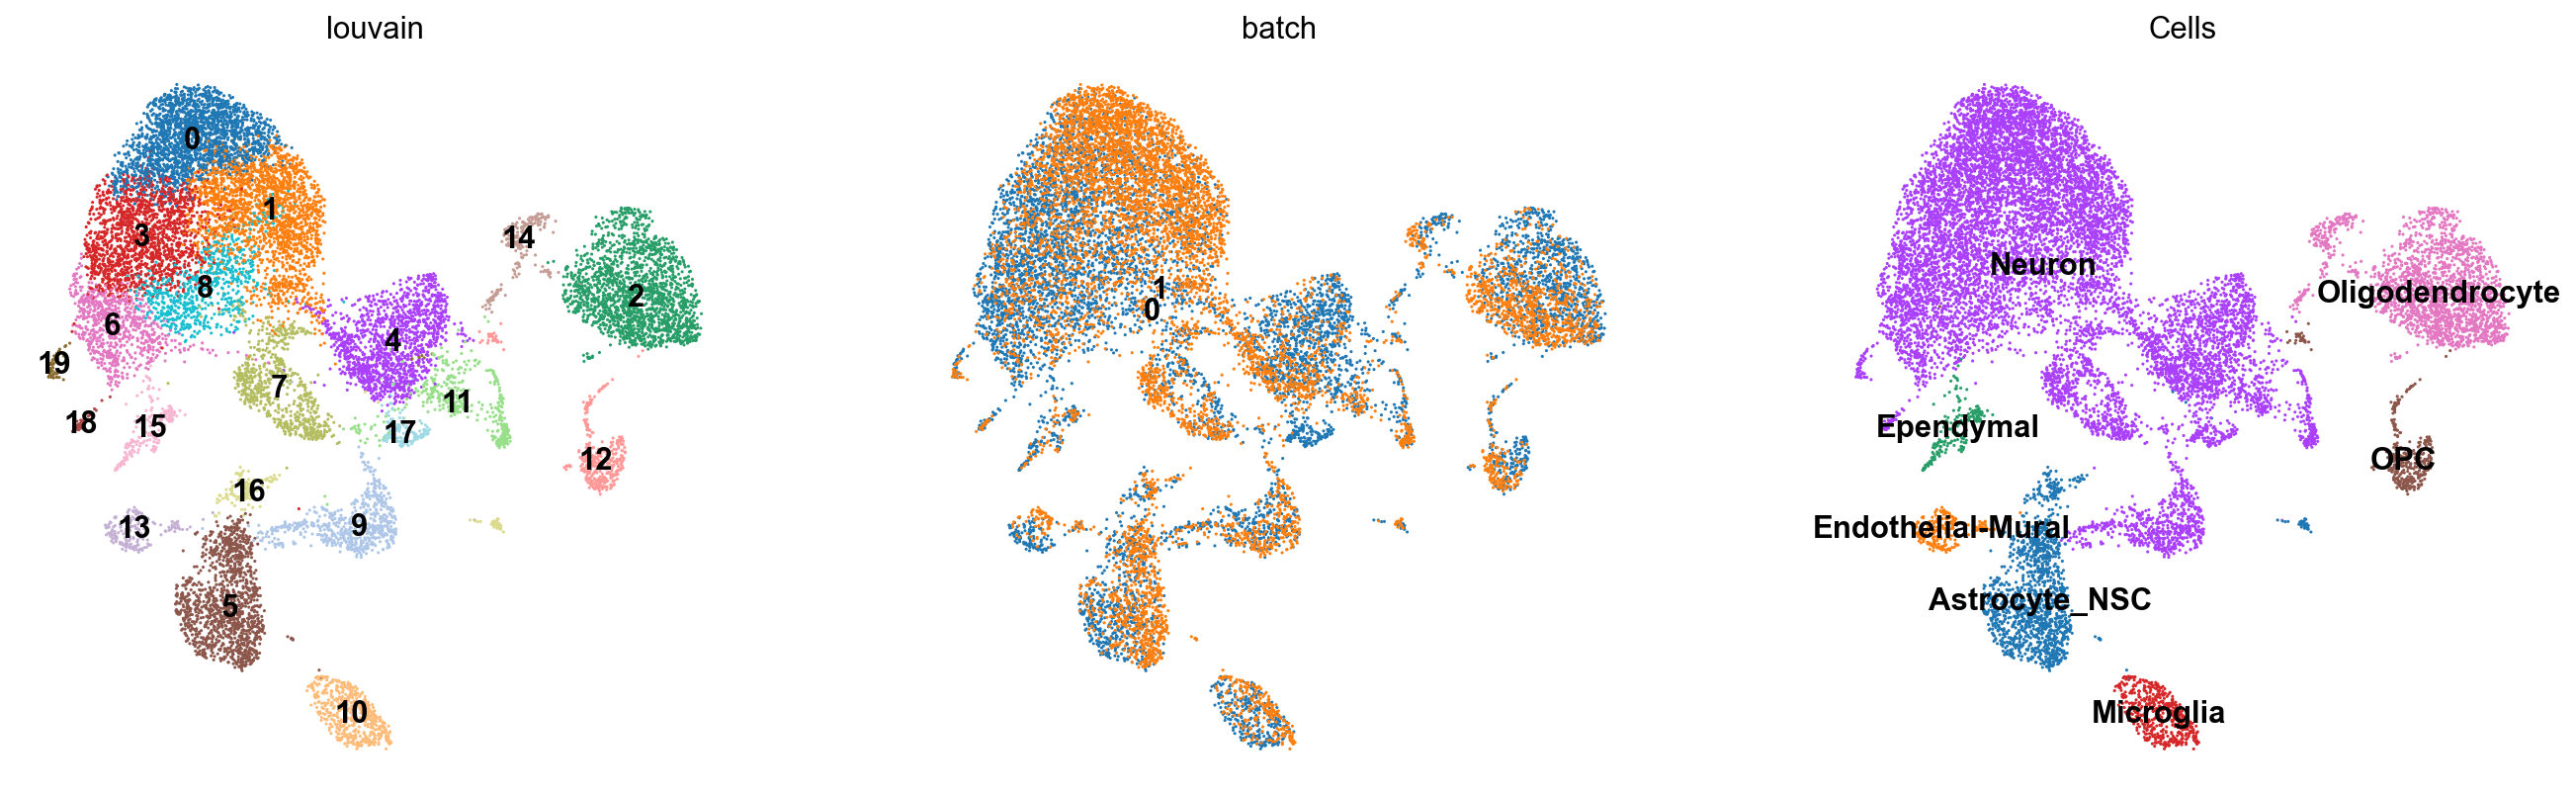

In [55]:
sc.settings.set_figure_params(figsize=(6,6))

sc.pl.umap(adata, color=['louvain', 'batch', 'Cells'], 
        frameon=False, legend_loc='on data')

# 08. KNN #

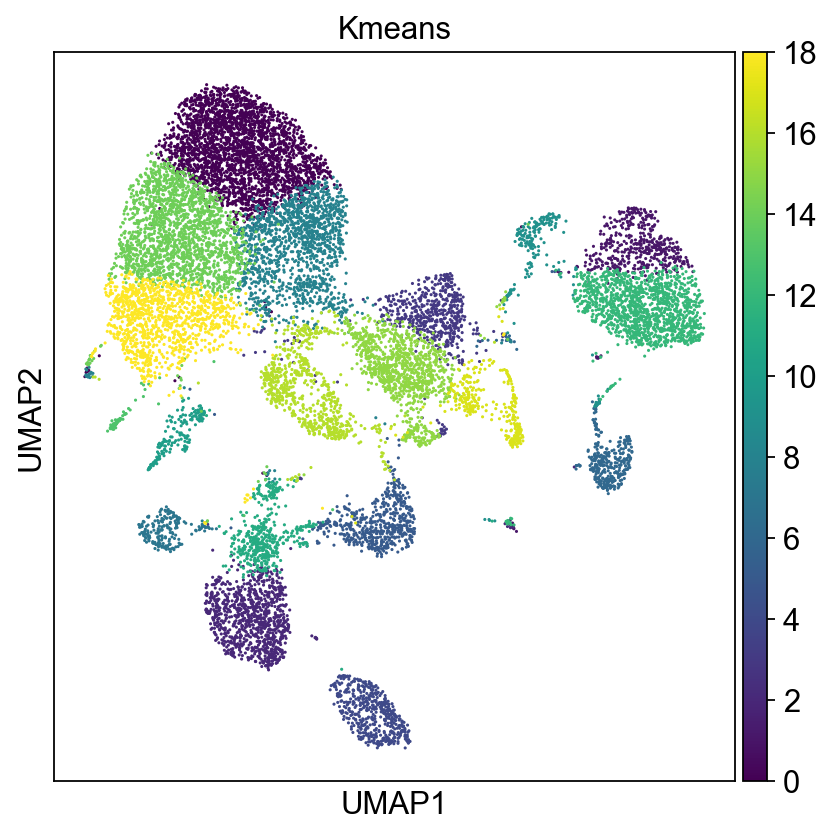

In [23]:
X_pca = adata.obsm['X_pca']
kmeans = KMeans(n_clusters=19).fit(X_pca)
adata.obs['Kmeans'] = kmeans.labels_
sc.pl.umap(adata, color='Kmeans')

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


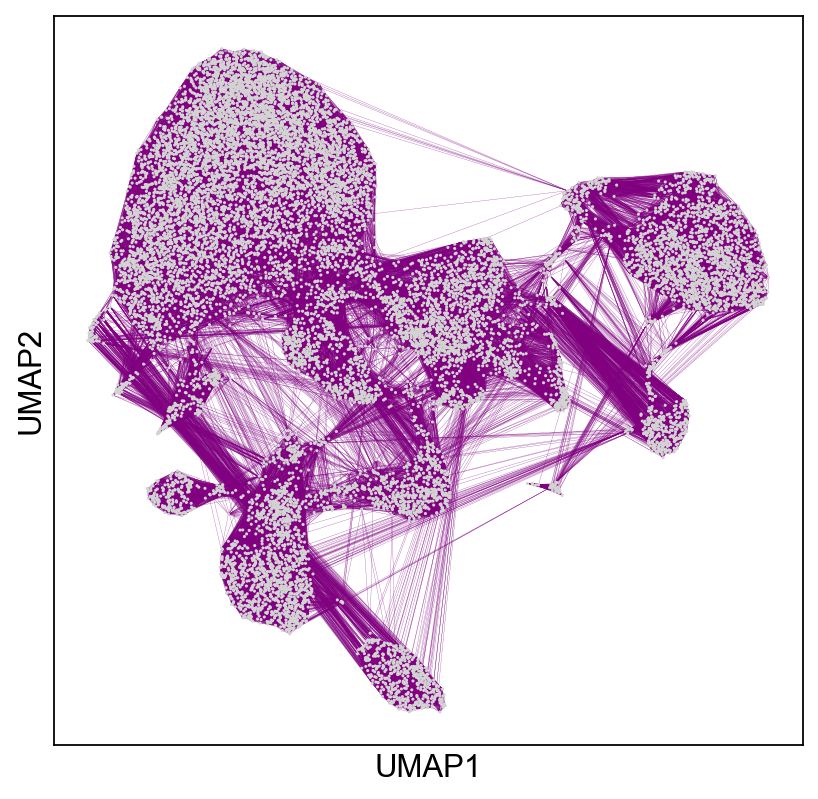

In [56]:
sc.pp.neighbors(adata, n_neighbors=30,n_pcs=10, metric='cosine') # based on the kmeans value
#sc.tl.umap(adata)
sc.pl.umap(adata, edges=True, edges_color='purple')

# 09. Trajectories Attempt #1 with PAGA and Zheng 2017 #


In [57]:
from matplotlib import rcParams 

In [58]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 5), facecolor='white')  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
certifi             2020.12.05
cffi                1.15.1
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.04.0
dateutil            2.8.1
decorator           5.0.6
fsspec              0.9.0
h5py                3.8.0
idna                2.10
igraph              0.10.4
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
jinja2              3.1.2
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.4.0
kiwisolver          1.3.1
leidenalg           0.9.1
llvmlite            0.36.0
louvain      

In [59]:
adata

AnnData object with n_obs × n_vars = 15272 × 2000
    obs: 'bTBI', 'condition', 'batch', 'n_genes', 'leiden', 'louvain', 'Cells'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'pca', 'umap', 'leiden', 'louvain', 'batch_colors', 'louvain_colors', 'rank_genes_groups', 'dendrogram_louvain', 'rank_genes_groups_filtered', 'Cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [60]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:00)


In [61]:
sc.tl.pca(adata, svd_solver='arpack') #try with n_comps =10

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [62]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:02:00)


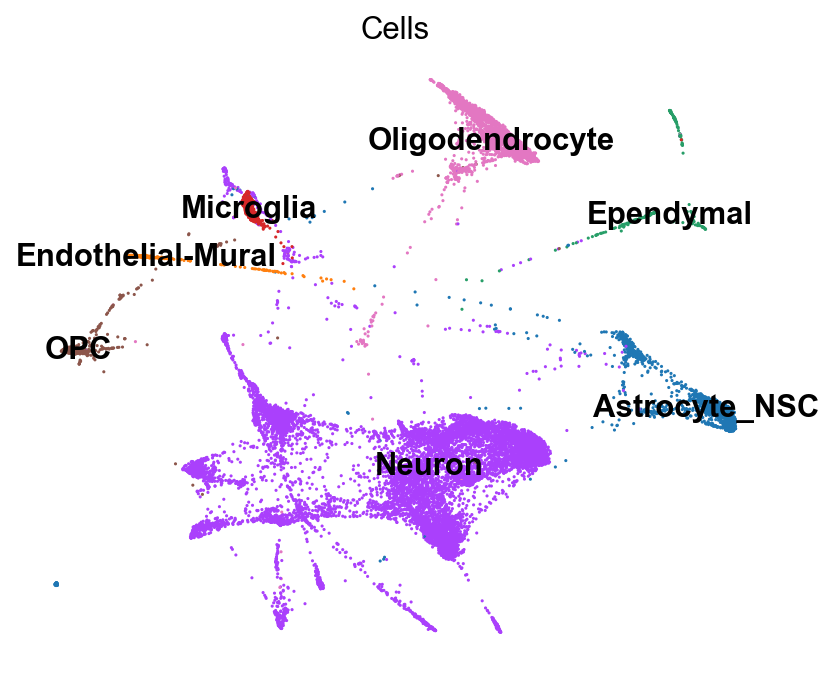

In [63]:
sc.pl.draw_graph(adata, color='Cells', legend_loc='on data')

In [64]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99980414 0.99971956 0.99964374 0.9995468
     0.9994034  0.9993273  0.9986503  0.99855036 0.99819547 0.9977616
     0.9975887  0.99723953 0.9971305 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [67]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 50 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [68]:
sc.tl.paga(adata, groups='Cells')
#sc.pl.umap(adata, color=['Cntnap2','Scl1a2']

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


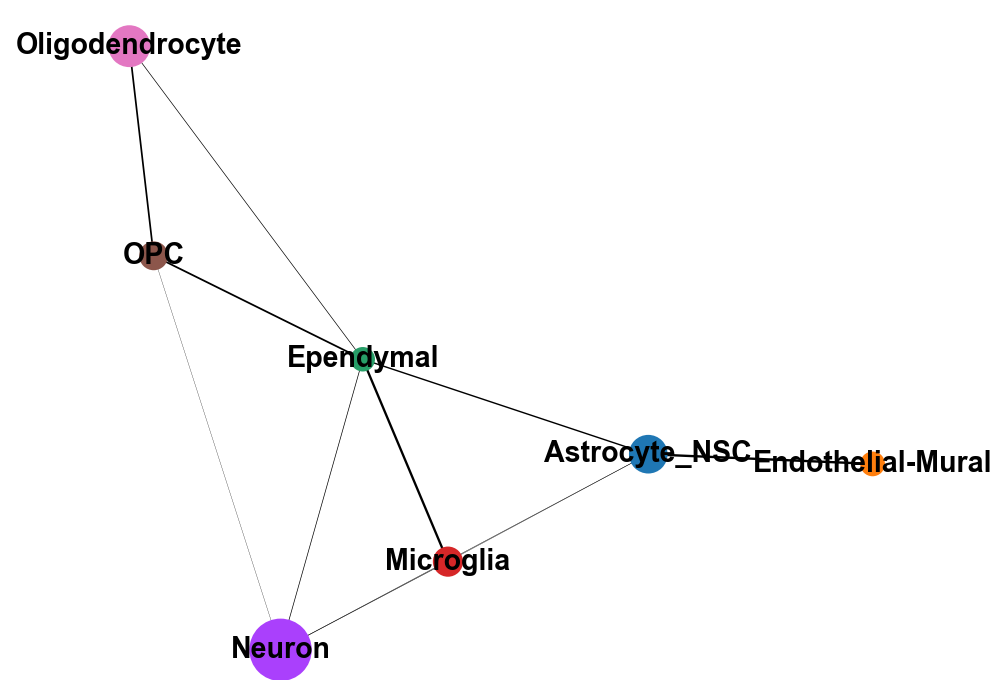

In [69]:
sc.pl.paga(adata, color=['Cells'])

# 10. Looking at Astrocytes-NSC and Ependymal Cells #

In [70]:
sc.settings.verbosity = 3
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:48)


In [71]:
astros = adata[adata.obs['Cells'] == 'Astrocyte_NSC', :]
epen  = adata[adata.obs['Cells'] == 'Ependymal', :]
opc = adata[adata.obs['Cells'] == 'OPC', :]
oligo= adata[adata.obs['Cells'] == 'Oligodendrocyte', :]

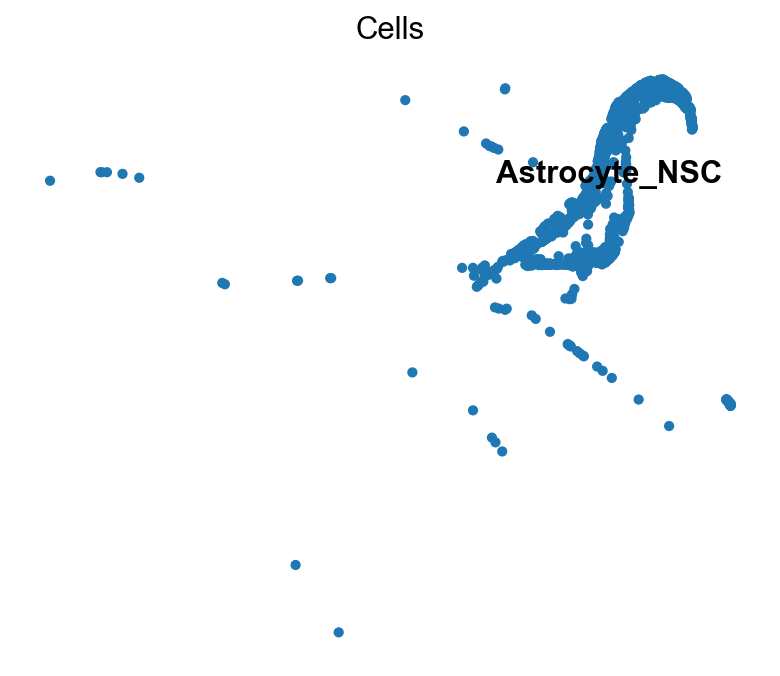

In [72]:
sc.pl.draw_graph(astros, color=['Cells'], legend_loc='on data')

In [79]:
astros.obs_names[150] #root cell ID, any cell in the Astrocycte cluster works 

'ATTTCTGTCGGCCCAA-1-0'

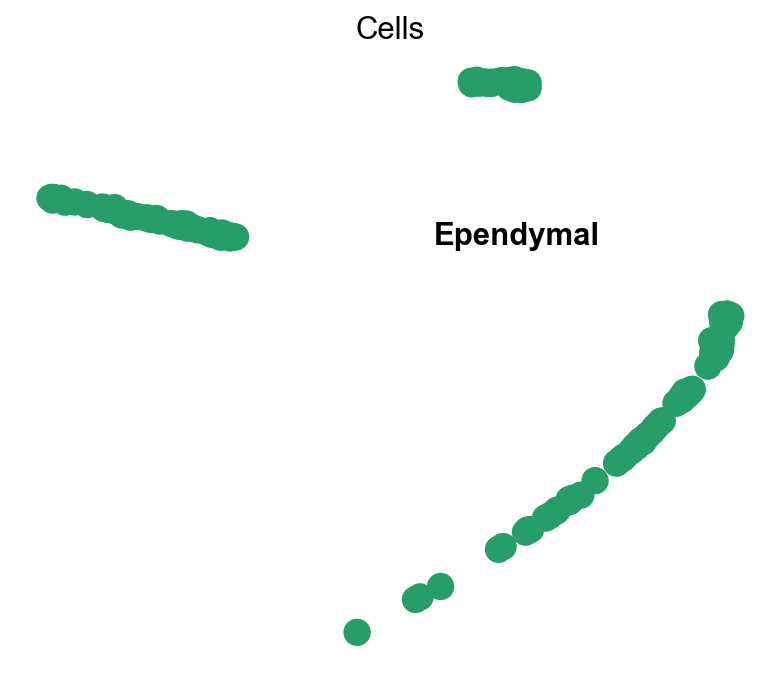

In [73]:
sc.pl.draw_graph(epen, color=['Cells'], legend_loc='on data')

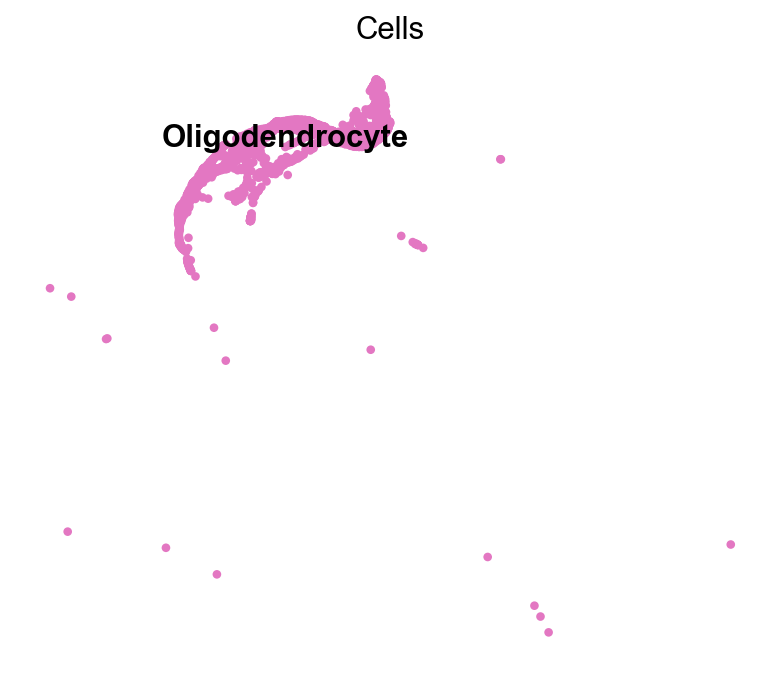

In [74]:
sc.pl.draw_graph(oligo, color=['Cells'], legend_loc='on data')

In [92]:
#adata.uns['iroot'] = np.flatnonzero(adata.obs['Cells'] == 'Astrocyte_NSC')

# 10. sc.diff and sc.dpt # 

In [82]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X', method='gauss')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)


In [83]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9912275  0.9782814  0.96341205 0.95649606 0.94802237
     0.94612426 0.9395539  0.9290032  0.9226112  0.9220328  0.9185107
     0.9151534  0.91313213 0.9108169 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [89]:
astros

AnnData object with n_obs × n_vars = 1418 × 999
    obs: 'bTBI', 'condition', 'batch', 'n_genes', 'leiden', 'louvain', 'Cells', 'n_counts_all'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'pca', 'umap', 'leiden', 'louvain', 'batch_colors', 'rank_genes_groups', 'dendrogram_louvain', 'rank_genes_groups_filtered', 'Cells_colors', 'draw_graph', 'diffmap_evals', 'paga', 'Cells_sizes', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [90]:
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)
astros.uns['iroot'] = 101
astros.var['xroot'] = astros['ATTTCTGTCGGCCCAA-1-0'].X #root_cell_name

    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Pseudotime using n_dcs=10
    finished: added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:10)


ValueError: Length of values (1) does not match length of index (999)

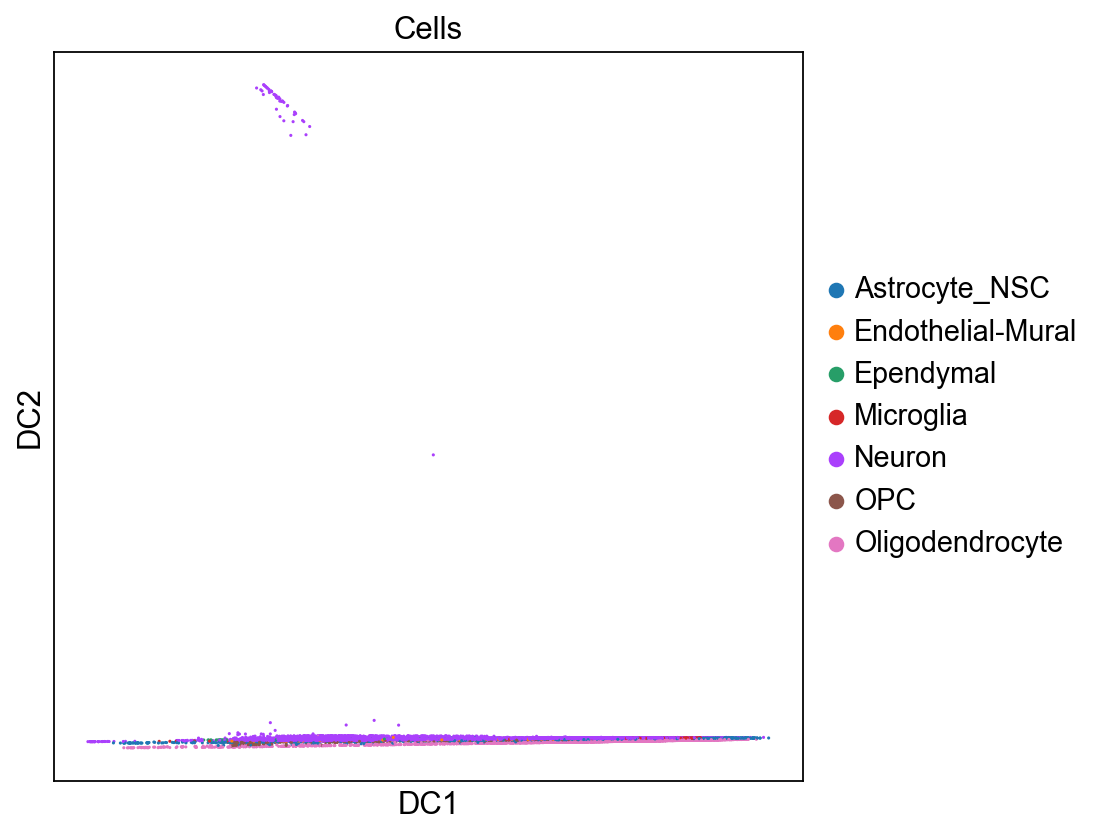

In [53]:
sc.pl.diffmap(adata, color=['Cells', 'dpt_pseudotime'])

# 11. Diffusion Maps and Palantir. Note: we decided to proceed with Diffusion analysis with Palantir # 

Person correlation with all the genes and get a scores, which genes have the most similar trajectory (GSA for pathways)

Palentir (Github)

In [91]:
import palantir
import warnings 
warnings.filterwarnings('ignore')

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [92]:
%matplotlib inline

sns.set_style('ticks')
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.cmap'] = 'Spectral_r'

In [93]:
pca_projections = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [94]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [97]:
sc.pp.neighbors(adata, n_neighbors=30,n_pcs=10, metric='cosine')
sc.tl.umap(adata) 

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


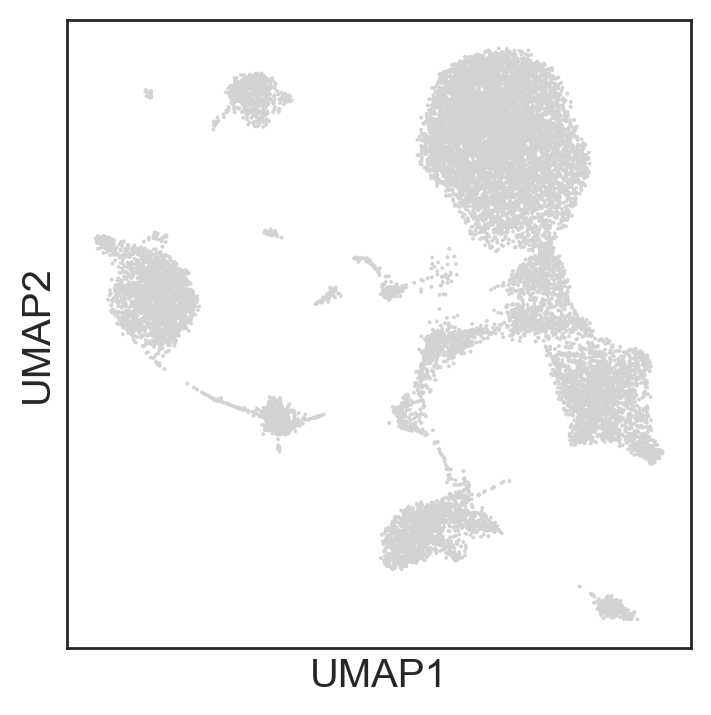

In [98]:
sc.pl.embedding(adata, basis='umap')

In [49]:
adata.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(adata, dm_res)

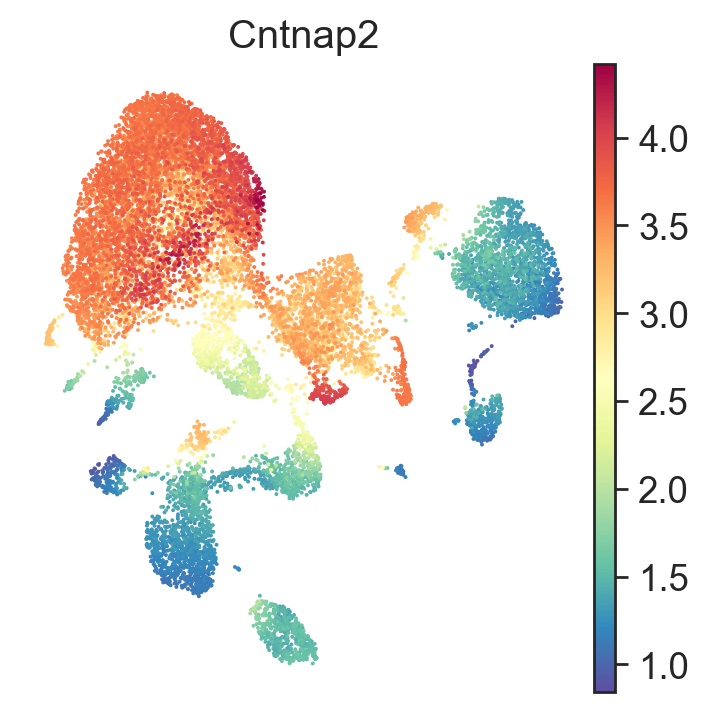

In [50]:
sc.pl.embedding(adata, basis='umap', layer='MAGIC_imputed_data',
               color=['Cntnap2']) #testing on Cntnap2 and then testing on the other marker genes that were idetified, find specific stemcell marker gene

In [56]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names) #dpt module 

In [72]:
astros

NameError: name 'astros' is not defined

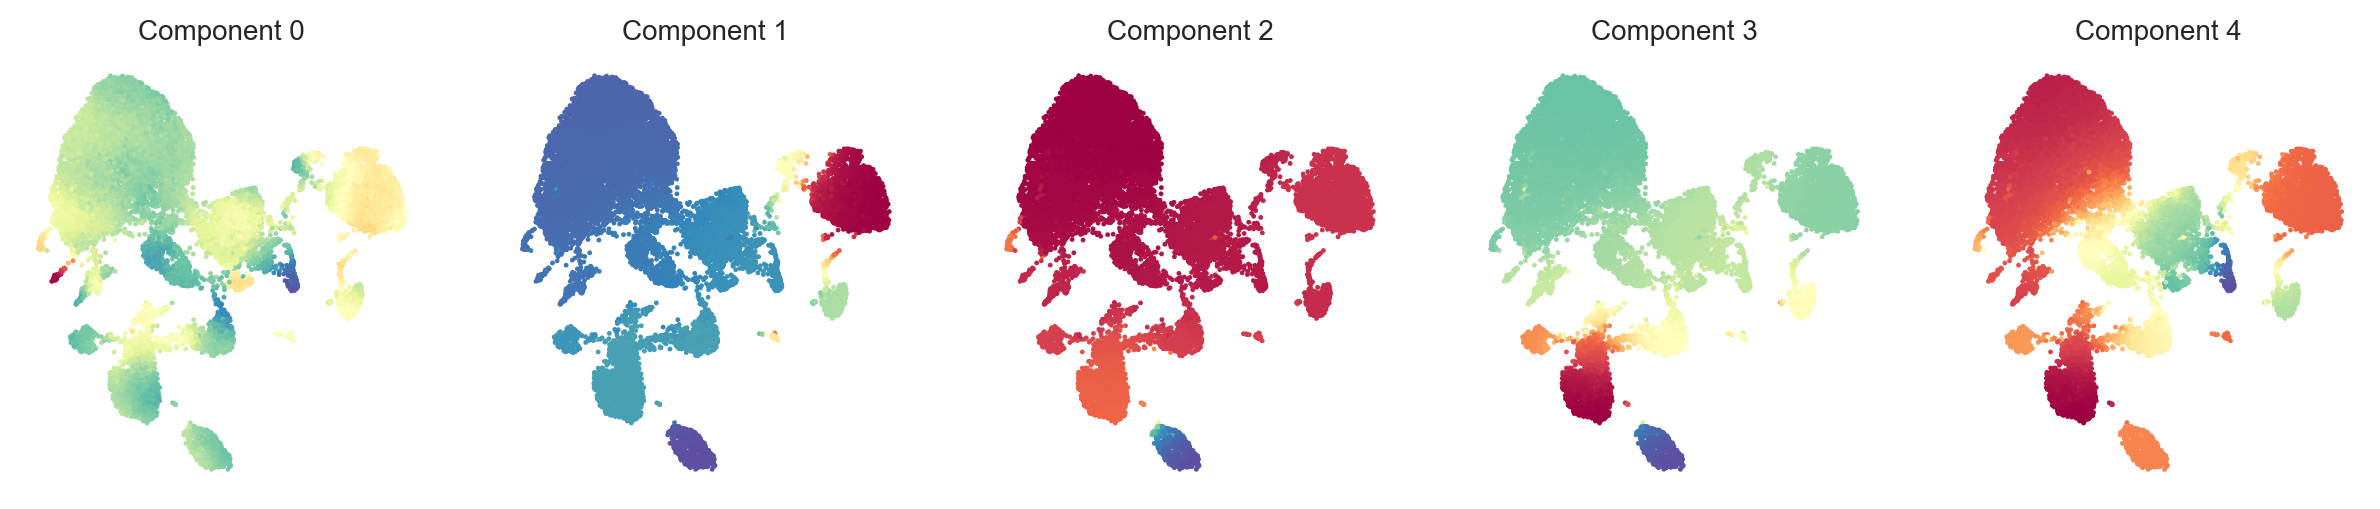

In [59]:
palantir.plot.plot_diffusion_components(umap, dm_res) #component 4 seems interesting

In [99]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [67]:
sc.tl.dpt(adata, n_dcs=10, n_branchings=1)

    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Pseudotime using n_dcs=10
    finished: added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:09)


In [68]:
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups'])

KeyError: 'Could not find key dpt_pseudotime in .var_names or .obs.columns.'

<Figure size 966x400 with 0 Axes>

In [85]:
start_cluster = adata[adata.obs['Cells'] == 'Neuron'[1], :]

In [86]:
sc.pl.draw_graph(start_cluster, color=['Cells'], legend_loc='on data')

KeyError: 'draw_graph'

In [76]:
QC_metrics[0]

n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCAAGCTGAAAT-1-0               3862                 8.259199   
AAACCCAAGTCATACC-1-0               1618                 7.389564   
AAACCCACAAGCGGAT-1-0               3759                 8.232174   
AAACCCACATGACTTG-1-0               1350                 7.208600   
AAACCCAGTATTAAGG-1-0               1911                 7.555905   
...                                 ...                      ...   
TTTGTTGGTAAGATTG-1-1               2932                 7.983781   
TTTGTTGGTACAGAGC-1-1               3573                 8.181441   
TTTGTTGGTATGCTTG-1-1               2352                 7.763446   
TTTGTTGGTCGTTGGC-1-1               3048                 8.022569   
TTTGTTGTCATTGCGA-1-1               3718                 8.221210   

                      total_counts  log1p_total_counts  \
AAACCCAAGCTGAAAT-1-0       12920.0            9.466609   
AAACCCAAGTCATACC-1-0        2969.0            7.996317   
AAACCCACAAGCGGAT-1-0       11413.0            9.342596   
AAACCCACATGACTTG-1-0        2210.0            7.701200   
AAACCCAGTATTAAGG-1-0        3600.0            8.188967   
...                            ...                 ...   
TTTGTTGGTAAGATTG-1-1        5619.0            8.634087   
TTTGTTGGTACAGAGC-1-1       11603.0            9.359105   
TTTGTTGGTATGCTTG-1-1        5634.0            8.636752   
TTTGTTGGTCGTTGGC-1-1        8687.0            9.069698   
TTTGTTGTCATTGCGA-1-1       13502.0            9.510667   

                      pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGCTGAAAT-1-0                   26.470588                    34.775542   
AAACCCAAGTCATACC-1-0                   25.530482                    32.637252   
AAACCCACAAGCGGAT-1-0                   29.720494                    36.607378   
AAACCCACATGACTTG-1-0                   24.886878                    32.488688   
AAACCCAGTATTAAGG-1-0                   24.944444                    32.111111   
...                                          ...                          ...   
TTTGTTGGTAAGATTG-1-1                   18.490835                    24.612920   
TTTGTTGGTACAGAGC-1-1                   25.269327                    34.715160   
TTTGTTGGTATGCTTG-1-1                   27.529286                    35.232517   
TTTGTTGGTCGTTGGC-1-1                   27.051917                    35.616438   
TTTGTTGTCATTGCGA-1-1                   29.462302                    38.268405   

                      pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  
AAACCCAAGCTGAAAT-1-0                    43.599071                    58.312693  
AAACCCAAGTCATACC-1-0                    42.910071                    62.344224  
AAACCCACAAGCGGAT-1-0                    45.264172                    58.713747  
AAACCCACATGACTTG-1-0                    42.488688                    61.538462  
AAACCCAGTATTAAGG-1-0                    41.500000                    59.111111  
...                                           ...                          ...  
TTTGTTGGTAAGATTG-1-1                    32.870618                    48.353800  
TTTGTTGGTACAGAGC-1-1                    45.255537                    60.113764  
TTTGTTGGTATGCTTG-1-1                    44.710685                    61.182109  
TTTGTTGGTCGTTGGC-1-1                    45.216991                    60.343041  
TTTGTTGTCATTGCGA-1-1                    47.866983                    62.035254  

[15272 rows x 8 columns]

In [87]:
adata

AnnData object with n_obs × n_vars = 15272 × 2000
    obs: 'bTBI', 'condition', 'batch', 'n_genes', 'leiden', 'louvain', 'Cells', 'Kmeans'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'pca', 'umap', 'leiden', 'louvain', 'batch_colors', 'louvain_colors', 'rank_genes_groups', 'dendrogram_louvain', 'rank_genes_groups_filtered', 'Cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'distances', 'connectivities'

In [ ]:
terminal_states = pd.Series(['DC', 'Mono', 'Ery'], 
                           index=['Run5_131097901611291', 'Run5_134936662236454', 'Run4_2005628693

In [ ]:
start_cell = 'Run5_164698952452459'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_sta

# Attempt at Monnocle but rpy2 is annoying #

In [ ]:
# import gseapy 
# import re
# import shutil

# #settings
# sc.settings.set_figure_params(dpi=200, facecolor='white')
# sc.settings.verbosity = 3

# #Data Preparation

# adata.layers["counts"] = adata.X.copy()
# data_mat_mon = adata.layers['counts'].T
# var_mon=adata.var.copy()
# obs_mon=adata.obs.copy()

In [ ]:
# # R libraries
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# from rpy2.robjects import numpy2ri
# from scipy.sparse import csc_matrix

# import rpy2.rinterface_lib.callbacks
# import logging

# from rpy2.robjects import pandas2ri
# import anndata2ri
# from gprofiler import gprofiler

# %load_ext rpy2.ipython
# #%reload_ext rpy2.ipython
# %matplotlib inline
# pandas2ri.activate()
# anndata2ri.activate()
# # Convert the dense NumPy array to an R object
# numpy2ri.activate()

In [ ]:
# library(scran)
# library(RColorBrewer)
# library(slingshot)
# library(monocle)
# library(gam)
# library(clusterExperiment)
# library(ggplot2)
# library(plyr)
# library(MAST)
# library(Seurat)
# library(tidyverse)
# library(magrittr)

In [ ]:
# data_mat_mon = adata.layers['counts'].T
# # var_mon=adata.var.copy()
# obs_mon=adata.obs.copy()

In [ ]:
# %%R -i data_mat_mon -i obs_mon -i var_mon
# pd <- AnnotatedDataFrame(data = obs_mon)
# # genes
# fd <- AnnotatedDataFrame(data = var_mon)
# # cell barcodes as columns of matrix
# colnames(data_mat_mon) <- rownames(pd)
# # genes as rows of matrix
# rownames(data_mat_mon) <- rownames(fd)
# ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())


In [ ]:
# #Normalize the count data
# ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

In [ ]:
# #Calculate dispersions to filter for highly variable genes
# ie_regions_cds <- estimateDispersions(ie_regions_cds)

In [ ]:
# #Do dimensionality reduction
# ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = T)

In [ ]:
# #Run for the first time to get the ordering
# ie_regions_cds <- orderCells(ie_regions_cds)


In [ ]:
# #Get a nice colour map
# custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$new_cluster)),'Paired')

In [ ]:
# #Find the correct root state that coresponds to the 'Stem' cluster
# tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$new_cluster)
# id = which(colnames(tab1) == 'MSC')
# root_name = names(which.max(tab1[,id]))

In [ ]:
# # Visualize with our cluster labels
# options(repr.plot.width=5, repr.plot.height=4)

In [ ]:
# cell_trajectory <- plot_complex_cell_trajectory(ie_regions_cds, color_by = new_cluster, show_branch_points = T, 
#                              cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
# scale_size(range = c(0.2, 0.2)) +
# theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
# guides(colour = guide_legend(override.aes = list(size=6))) + 
# scale_color_manual(values = custom_colour_map)
# cell_trajectory